# Flower GAN
GAN for generating images of flowers

In [1]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time

Setup kaggle environment

In [3]:
from google.colab import drive

# Setup API token
drive.mount("/content/gdrive")
!mkdir ~/.kaggle
!cp gdrive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle
!pip install kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
# Download dataset
!kaggle datasets download -d l3llff/flowers

flowers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Unzip dataset
!unzip flowers.zip

Archive:  flowers.zip
replace flowers/astilbe/10091895024_a2ea04cda6_c.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
BUFFER_SIZE = 16000
BATCH_SIZE = 32

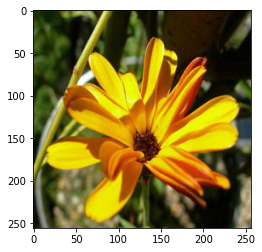

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("flowers/calendula/1010982154_242fbe2cb0_c.jpg")
imgplot = plt.imshow(img)
plt.show()

In [8]:
IMG_SIZE = [224, 224, 3]
NUM_CLASSES = 16

In [9]:
# Load dataset
flowers_dataset = tf.keras.utils.image_dataset_from_directory(
    "flowers",
    labels=None,                          # No labels required for this
    image_size=[IMG_SIZE[0], IMG_SIZE[1]] # Resize the image
)

Found 15740 files belonging to 1 classes.


In [10]:
# Make generator network
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NUM_CLASSES,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 112, 112, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    print(model.output_shape)
    assert model.output_shape == (None, IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2])

    return model

(None, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


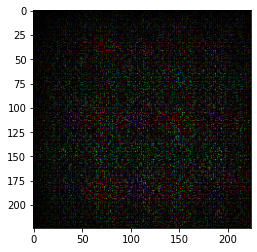

In [11]:
# Test (untrained) generator
generator = make_generator_model()

noise = tf.random.normal([1, NUM_CLASSES])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0] * 255)

In [12]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             200704    
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [13]:
# Make discriminator network
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=IMG_SIZE))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
# Test (untrained) discriminator
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[4.2744934e-05]], shape=(1, 1), dtype=float32)


In [15]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      4864      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 112, 112, 64)      0         
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 128)       204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 56, 56, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)      

In [16]:
# Loss function and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
# Separate optimizers, as they don't train simultaneously
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
# Training loop
EPOCHS = 10
noise_dim = NUM_CLASSES
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # print("Generating...")
      generated_images = generator(noise, training=True)
      # print("Generated shape {}".format(generated_images.shape))
      # print("Discriminating...")
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    # print("Epoch {}".format(epoch))
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    #generate_and_save_images(generator,
     #                        epoch + 1,
      #                       seed)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
     # checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator, epochs, seed)


In [28]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(16, 16))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i] * 128)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


Time for epoch 1 is 130.9004156589508 sec
Time for epoch 2 is 131.17570662498474 sec
Time for epoch 3 is 131.48509430885315 sec
Time for epoch 4 is 131.87354564666748 sec
Time for epoch 5 is 131.7355353832245 sec
Time for epoch 6 is 131.46075749397278 sec
Time for epoch 7 is 131.62435817718506 sec
Time for epoch 8 is 131.6575562953949 sec
Time for epoch 9 is 131.70934510231018 sec
Time for epoch 10 is 131.6111671924591 sec


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

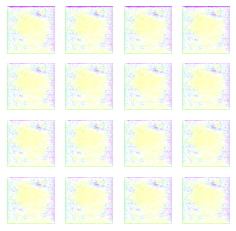

In [24]:
# Train
train(flowers_dataset, EPOCHS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

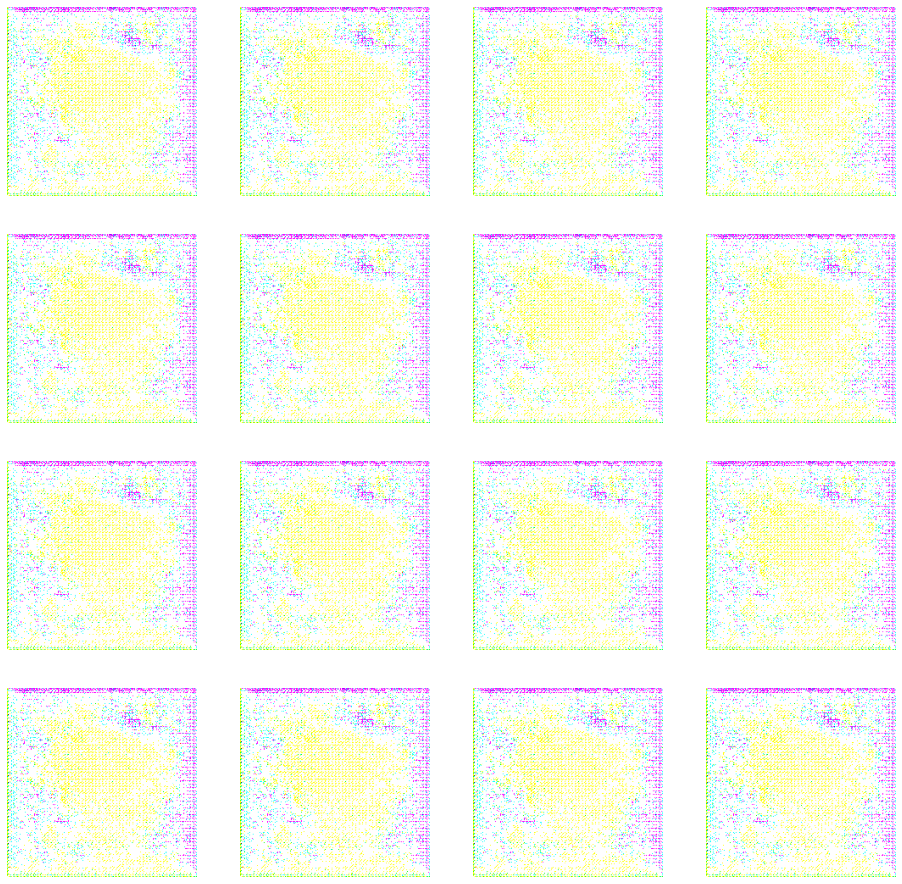

In [29]:
generate_and_save_images(generator, EPOCHS, seed)